In [2]:
import os
import sys
import json
import warnings
import numpy as np
import xarray as xr
import proplot as pplt
warnings.filterwarnings('ignore')
pplt.rc.update({'reso':'xx-hi','figure.dpi':100})

In [3]:
with open('/global/cfs/cdirs/m4334/sferrett/monsoon-kernels/scripts/configs.json','r',encoding='utf-8') as f:
    CONFIGS = json.load(f)
SPLITSDIR  = CONFIGS['filepaths']['splits']    
MODELSDIR  = CONFIGS['filepaths']['models']
PREDSDIR   = CONFIGS['filepaths']['predictions']
MODELS     = CONFIGS['models']
SPLIT      = 'valid'   

In [4]:
with xr.open_dataset(os.path.join(SPLITSDIR,f'{SPLIT}.h5'),engine='h5netcdf') as ds:
    truepr = ds.pr.load()

results = {}
for model in MODELS:
    name,description = model['name'],model['description']
    filename = f'{name}_{SPLIT}_predictions.nc'
    filepath = os.path.join(PREDSDIR,filename)
    if os.path.exists(filepath):
        with xr.open_dataset(filepath,engine='h5netcdf') as ds:
            predpr = ds.pr.load()
        ytrue,ypred = xr.align(truepr,predpr,join='inner')
        results[name] = dict(description=description,ytrue=ytrue,ypred=ypred)
print(f'Found {len(results)} completed models for `{SPLIT}`')

Found 8 completed models for `valid`


In [5]:
def get_r2(ytrue,ypred,dims=None):
    dims  = list(ytrue.dims) if dims is None else dims
    ssres = ((ytrue-ypred)**2).sum(dim=dims,skipna=True)
    sstot = ((ytrue-ytrue.mean(dim=dims,skipna=True))**2).sum(dim=dims,skipna=True)
    return 1-ssres/sstot

In [10]:
barsdata = []
for runname,result in results.items():
    description = result['description']
    ytrue,ypred = result['ytrue'],result['ypred']
    r2     = get_r2(ytrue,ypred,dims=None)
    color = (
    'yellow3' if 'nonparametric' in runname
    else 'red4' if any(k in runname for k in ('tophat','gaussian','exponential'))
    else 'blue4')
    barsdata.append((runname,description,r2,color))
barsdata = sorted(barsdata,key=lambda x:x[2])

labels = [item[1] for item in barsdata]
r2s    = [item[2] for item in barsdata]
colors = [item[3] for item in barsdata]

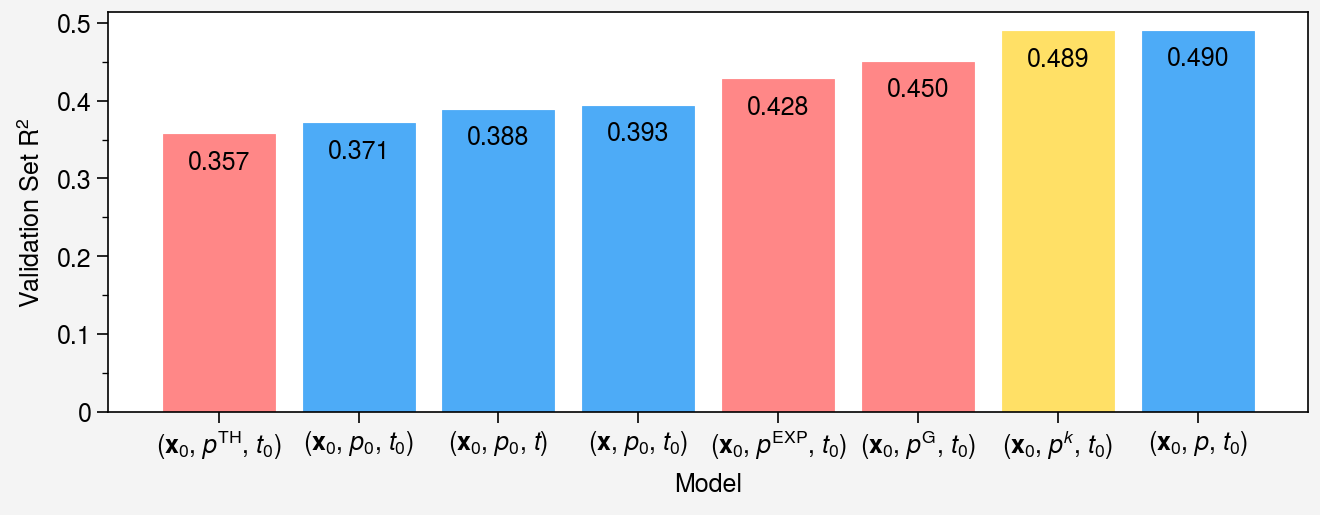

In [11]:
fig,ax = pplt.subplots(nrows=1,ncols=1,refwidth=6,refheight=2)
ax.format(xlabel='Model',ylabel='Validation Set R$^2$',yticks=0.1,yminorticks=0.05,grid=False)
bars = ax.bar(labels,r2s,color=colors,capsize=3)
for bar,r2 in zip(bars,r2s):
    ax.text(bar.get_x()+bar.get_width()/2,bar.get_height()-0.02,f'{r2:.3f}',ha='center',va='top')
pplt.show()